In [24]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords, gutenberg

In [28]:
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [2]:
random_state = 111111
rnd.seed(random_state)

In [3]:
def histplot(df: pd.DataFrame, bins=60, column=None, xlabel=None, ylabel="Frequency", title=None, **plot_args):
    if column is None:
        column = df.columns[0]

    if xlabel is None:
        xlabel = column

    if title is None:
        title = f'Distribution of {column}'

    # Create a histogram to visualize the distribution of sentence lengths
    plt.hist(df[column], bins=bins, **plot_args)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [4]:
df = pd.read_csv("eng_sents.csv", names=["sentences"])
df.describe()

,sentences
count,28806
unique,28806
top,Children who spend more time outdoors have a l...
freq,1


## Preprocessing

The longest (by number of words) sentences are unrealistic so we do a two-step filter:

1. Remove sentences longer than some fixed threshold $L_{max} := 400$ 
2. Of those remaining, keep only those who are in the $p := 0.8$ fraction closest to the median
3. Of those remaining, keep a randomly selected subset of size $s := 4000$

In [5]:
df["sent-len"] = df["sentences"].apply(len)
df["sent-len"].describe()

count    28806.000000
mean        74.371589
std         64.679002
min          3.000000
25%         30.000000
50%         48.000000
75%        103.000000
max        855.000000
Name: sent-len, dtype: float64

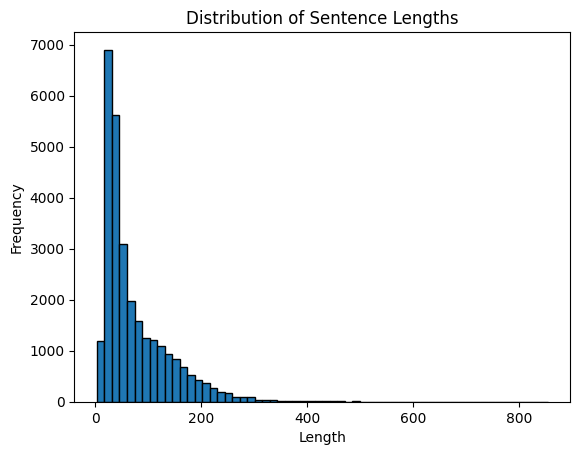

In [6]:
histplot(df, column="sent-len", xlabel="Length", edgecolor="k")

In [7]:
Lmin = 10
Lmax = 300
df1 = df[df["sent-len"].between(Lmin, Lmax, inclusive="both")]

In [8]:
df1["sent-len"].describe()

count    28528.000000
mean        71.957095
std         58.032531
min         10.000000
25%         30.000000
50%         48.000000
75%        101.000000
max        300.000000
Name: sent-len, dtype: float64

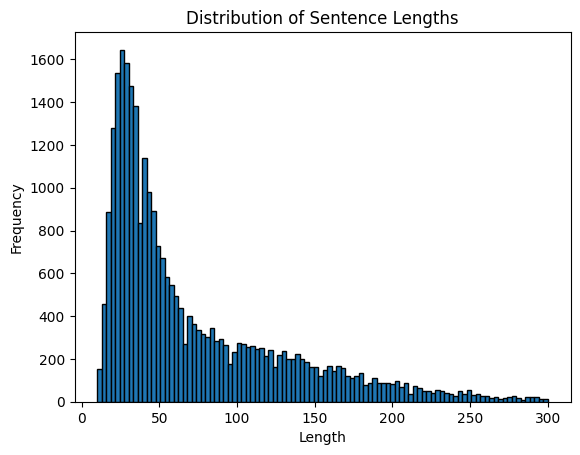

In [9]:
histplot(df1, bins=100, column="sent-len", xlabel="Length", edgecolor="k")

In [10]:
p=0.8
total_left = len(df1)
to_extract = int(p * total_left)

med_len = df1["sent-len"].median()
df1['len-diff'] = abs(df1['sent-len'] - med_len)
df2 = df1.sort_values(by="len-diff").head(n=to_extract)

len(df2)

C:\Users\andre\AppData\Local\Temp\ipykernel_19904\1359016915.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['len-diff'] = abs(df1['sent-len'] - med_len)


22822

In [11]:
df2["sent-len"].describe()

count    22822.000000
mean        47.221102
std         26.363422
min         10.000000
25%         27.000000
50%         39.000000
75%         62.000000
max        117.000000
Name: sent-len, dtype: float64

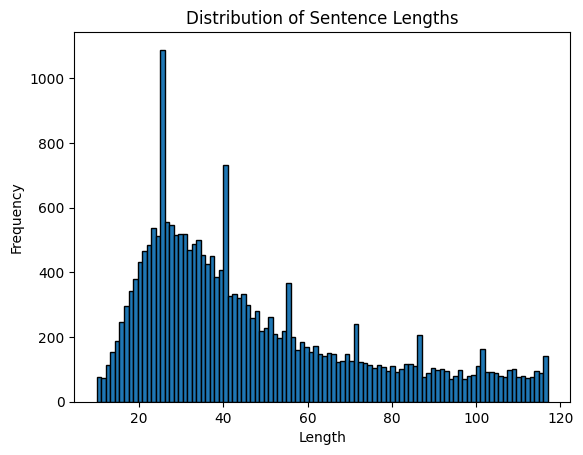

In [12]:
histplot(df2, bins=100, column="sent-len", xlabel="Length", edgecolor="k")

In [13]:
data = df2["sentences"].sample(n=4000, random_state=random_state).to_frame()
data.describe()

,sentences
count,4000
unique,4000
top,It's a popular song based off of something Rab...
freq,1


In [14]:
data.head()

,sentences
14812,It's a popular song based off of something Rab...
18724,Tom is learning Krav Maga.
16937,"You are welcome, Ravi."
7040,I'm named after my late grandfather.
13170,Have you seen my highlighter?


## (pseudo-)Aphasic text generation

### N-gram model

Creation of an n-gram character LM from text for word variant scoring

In [77]:
src_title = "melville-moby_dick.txt"

In [87]:
source_sents = gutenberg.sents(src_title)
source_sents = [[c for w in s for c in w] for s in source_sents]

print(*source_sents[:10], sep="\n")

['[', 'M', 'o', 'b', 'y', 'D', 'i', 'c', 'k', 'b', 'y', 'H', 'e', 'r', 'm', 'a', 'n', 'M', 'e', 'l', 'v', 'i', 'l', 'l', 'e', '1', '8', '5', '1', ']']
['E', 'T', 'Y', 'M', 'O', 'L', 'O', 'G', 'Y', '.']
['(', 'S', 'u', 'p', 'p', 'l', 'i', 'e', 'd', 'b', 'y', 'a', 'L', 'a', 't', 'e', 'C', 'o', 'n', 's', 'u', 'm', 'p', 't', 'i', 'v', 'e', 'U', 's', 'h', 'e', 'r', 't', 'o', 'a', 'G', 'r', 'a', 'm', 'm', 'a', 'r', 'S', 'c', 'h', 'o', 'o', 'l', ')']
['T', 'h', 'e', 'p', 'a', 'l', 'e', 'U', 's', 'h', 'e', 'r', '-', '-', 't', 'h', 'r', 'e', 'a', 'd', 'b', 'a', 'r', 'e', 'i', 'n', 'c', 'o', 'a', 't', ',', 'h', 'e', 'a', 'r', 't', ',', 'b', 'o', 'd', 'y', ',', 'a', 'n', 'd', 'b', 'r', 'a', 'i', 'n', ';', 'I', 's', 'e', 'e', 'h', 'i', 'm', 'n', 'o', 'w', '.']
['H', 'e', 'w', 'a', 's', 'e', 'v', 'e', 'r', 'd', 'u', 's', 't', 'i', 'n', 'g', 'h', 'i', 's', 'o', 'l', 'd', 'l', 'e', 'x', 'i', 'c', 'o', 'n', 's', 'a', 'n', 'd', 'g', 'r', 'a', 'm', 'm', 'a', 'r', 's', ',', 'w', 'i', 't', 'h', 'a', 'q', 

In [113]:
# Create an N-gram model of the source text
from nltk.lm.preprocessing import padded_everygram_pipeline

n_gram_size = 4

train, vocab = padded_everygram_pipeline(n_gram_size, source_sents)

In [133]:
from nltk.lm.smoothing import Smoothing

#TODO: Actually implement Katz smoothing (somehow)
class KatzSmoothing(Smoothing):
    def __init__(self, vocabulary, count, gamma=0.5):
        super().__init__(vocabulary, count)
        self.gamma = gamma

    def unigram_score(self, word, context=None):
        return self.gamma / self.counts[0]

    def alpha_gamma(self, word, context):
        return self.gamma

    def discount(self):
        return self.gamma

    def __str__(self):
        return f"KatzSmoothing(gamma={self.gamma})"

In [114]:
from nltk.lm import MLE

mle = MLE(n_gram_size)

In [115]:
mle.fit(text=train, vocabulary_text=vocab)

In [116]:
mle.generate(5)

['i', 's', 'h', 'i', 'g']

### Data generation

In [117]:
def insert_rand_char(word, charset=string.ascii_lowercase):
    l = len(word)
    idx = rnd.randint(l)
    char_idx = rnd.randint(len(charset))
    char = charset[char_idx]

    return f"{word[:idx]}{char}{word[idx:]}"

def delete_rand_char(word):
    l = len(word)
    idx = rnd.randint(l)

    return f"{word[:idx]}{word[idx+1:]}"

def swap_rand_chars(word):
    l = len(word)
    if l < 2:
        return word

    idx1, idx2 = sorted(rnd.choice(range(l), size=2, replace=False))

    c1, c2 = word[idx1], word[idx2]

    return f"{word[:idx1]}{c2}{word[idx1+1:idx2]}{c1}{word[idx2+1:]}"

def alter_word(word, n_changes=1):
    changes = rnd.choice(["I", "D", "S"], size=n_changes)
    iscapitalized = word[0].isupper()

    output = word
    for i in range(n_changes):
        if changes[i] == "I":
            output = insert_rand_char(output)
        elif changes[i] == "D":
            output = delete_rand_char(output)
        elif changes[i] == "S":
            output = swap_rand_chars(output)
            
    if iscapitalized:
        output = output.capitalize()

    return output

In [118]:
alter_word("ciaone")

'ceiaone'

In [128]:
def score_variant(variant, context):
    variant_chars = [c for c in variant]
    context_chars = [c for c in context]

    """scores = [mle.logscore(vc, cc) for vc, cc in zip(variant_chars, context_chars)]

    return sum(scores) / len(variant)"""

    return mle.logscore(variant_chars, context_chars)

def get_best_variant(word, context, var_count=10, max_iter=20):
    variants = [""] * var_count
    scores = [0.] * var_count

    for i in range(var_count):
        for _ in range(max_iter):
            new_var = alter_word(word)
            if not new_var in variants:
                variants[i] = new_var
                scores[i] = score_variant(new_var, context)
                break

    selected = np.argmax(scores)

    return variants[selected]

def alter_sentence(sent, p=0.4, ng_size = n_gram_size, var_count=10):
    output = ""
    #TODO: Should probably tokenize better with nltk instead of just splitting on spaces
    words = sent.split(" ")
    current_idx = 0

    for idx, w in enumerate(words):
        current_idx += len(w)
        # Unless it's the last word, add a space
        if idx < len(words) - 1:
            current_idx += 1

        w2 = w

        if rnd.rand() < p:
            # Pass as context the previous 2 characters in sent
            start = max(0, current_idx - ng_size)
            context = sent[start:current_idx]

            w2 = get_best_variant(w, context=context, var_count=var_count)

        output += f"{w2} "

    return output.strip() # remove trailing whitespace

In [129]:
alter_sentence("how is it going big guy")

'hw is ti going big guqy'

In [130]:
data_altered = data.copy()

In [131]:
data_altered["sents-alt"] = data_altered["sentences"].apply(alter_sentence)

In [132]:
data_altered.head()

,sentences,sents-alt
14812,It's a popular song based off of something Rab...,It's ba poipular song besad off of something R...
18724,Tom is learning Krav Maga.,Tom is learning Mkrav Maga.
16937,"You are welcome, Ravi.","You ae welcome, Rav."
7040,I'm named after my late grandfather.,'m named after my leta grandfatkher.
13170,Have you seen my highlighter?,Heva you yseen nmy highlighte?
